# Build models using vitals data

## Read data

In [1]:
import os
from pathlib import Path

import pandas as pd


dataDirName = Path(os.environ['DATA_DIR'], 'sepsis_prediction', 'lstm_initial_trials', '02_data_matrix', 'balanced_data')
dataDirName.mkdir(exist_ok=True, parents=True)

dataDf = pd.read_csv(Path(dataDirName, 'data_all_variables.csv'))
dataDf = dataDf.sort_values(by=['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime'], ascending=True)
dataDf

,PATIENT_ID,EPISODE_ID,measurement_datetime,Diastolic blood pressure_mean,Diastolic blood pressure_min,Diastolic blood pressure_max,Diastolic blood pressure_first,Diastolic blood pressure_last,Diastolic blood pressure_std,Heart rate_mean,...,Systolic blood pressure_std,Temperature_mean,Temperature_min,Temperature_max,Temperature_first,Temperature_last,Temperature_std,Organism_FIRST_NOTED,sepsis,target
0,18849,12790706,2019-09-01,63.750000,50.0,74.0,74.0,69.0,7.497619,96.500,...,12.199971,37.477778,35.5,40.6,35.5,36.9,1.605286,2019-09-01,0.0,0.0
1,18849,12790706,2019-09-02,55.750000,48.0,61.0,54.0,48.0,6.020797,88.000,...,7.788881,36.875000,36.2,38.1,36.8,36.4,0.853913,2019-09-01,0.0,0.0
2,18849,12790706,2019-09-03,55.000000,47.0,69.0,48.0,47.0,10.165300,90.000,...,8.341663,36.750000,36.1,37.7,37.7,36.1,0.695222,2019-09-01,0.0,0.0
3,53162,15749998,2021-11-29,80.076923,70.0,91.0,75.0,86.0,6.264470,85.250,...,13.171940,36.225000,35.9,36.7,36.2,36.7,0.340343,2022-01-06,0.0,0.0
4,53162,15749998,2021-11-29,80.076923,70.0,91.0,75.0,86.0,6.264470,85.250,...,13.171940,36.225000,35.9,36.7,36.2,36.7,0.340343,2022-01-06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103753,2676371,17444357,2023-04-14,76.000000,64.0,105.0,65.0,68.0,14.302847,72.625,...,9.739463,36.725000,36.1,37.2,36.9,36.8,0.353553,2023-04-21,0.0,0.0
103754,2676371,17444357,2023-04-15,69.800000,61.0,77.0,75.0,61.0,6.379655,89.000,...,12.502000,36.875000,36.6,37.1,37.1,37.1,0.262996,2023-04-21,0.0,0.0
103755,2676371,17444357,2023-04-15,69.800000,61.0,77.0,75.0,61.0,6.379655,89.000,...,12.502000,36.875000,36.6,37.1,37.1,37.1,0.262996,2023-04-21,0.0,0.0
103756,2676371,17444357,2023-04-15,69.800000,61.0,77.0,75.0,61.0,6.379655,89.000,...,12.502000,36.875000,36.6,37.1,37.1,37.1,0.262996,2023-04-21,0.0,0.0


In [2]:
dataDf.sepsis.value_counts()/dataDf.shape[0]

sepsis
1.0    0.849322
0.0    0.150678
Name: count, dtype: float64

In [3]:
dataDf.target.value_counts()/dataDf.shape[0]

target
0.0    0.575503
1.0    0.424497
Name: count, dtype: float64

In [4]:
rowsX = []
rowsY = []
for name, group in dataDf.groupby(by=['PATIENT_ID', 'EPISODE_ID']):
    low = 0
    high = 3
    while high <= group.shape[0]:
        valuesList = []
        for col in dataDf.columns[~dataDf.columns.isin(['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime', 'Organism_FIRST_NOTED', 'sepsis', 'target'])]:
            valuesList.append(list(group[col][low: high]))
        rowsX.append(
            [[*x] for x in zip(*valuesList)]
            )
        rowsY.append(group.target[(high - 1): high].values[0])
        high += 1
        low += 1

In [5]:
import numpy as np


X = np.array(rowsX)
Y = np.array(rowsY)

In [6]:
X.shape, Y.shape

((100984, 3, 42), (100984,))

In [7]:
np.unique(Y, return_counts=True)[1]/Y.shape[0]

array([0.56757506, 0.43242494])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((80787, 3, 42), (20197, 3, 42), (80787,), (20197,))

## LSTM using Pytorch

In [9]:
import torch
from torch import nn
import torch.utils.data as data

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

loader = data.DataLoader(data.TensorDataset(X_train_tensor, Y_train_tensor), shuffle=False, batch_size=1024)


In [11]:
print(X_train_tensor.shape, Y_train_tensor.shape, X_test_tensor.shape, Y_test_tensor.shape)

torch.Size([80787, 3, 42]) torch.Size([80787]) torch.Size([20197, 3, 42]) torch.Size([20197])


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [13]:
class LstmModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=42, hidden_size=1024, num_layers=1, batch_first=True)
        self.linear = nn.Linear(1024, 1)

    def forward(self, x):
        x, _ = self.lstm(x)          # -> (batch_size, seq_len, n_hidden)
        x = x[:, -1, :]
        x = self.linear(x)                  # -> (batch_size * seq_len, vocab_size)
        return x

In [25]:
model = LstmModel().to(device)
model

LstmModel(
  (lstm): LSTM(42, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)

In [26]:
learning_rate = 0.001

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [27]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [30]:
# Number of epochs
epochs = 1000

# Send data to the device
# x_train, x_valid = x_data.to(device), x_data.to(device)
# y_train, y_valid = y_data.to(device), y_data.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    for X_batch, y_batch in loader:
        y_logits = model(X_batch).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
        y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

        # print(y_logits.shape, y_batch.shape)

        loss = loss_fn(y_logits, y_batch) # compute the loss
        acc = accuracy_fn(y_batch.int(), y_pred) # calculate the accuracy; convert the labels to integers

        optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
        loss.backward() # backward pass: backpropagate the prediction loss
        optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass

    # Print progress a total of 20 times
    if epoch % int(epochs / 200) == 0:
        # Put the model in evaluation mode
        model.eval()

        with torch.inference_mode():
            y_logits = model(X_train_tensor).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

            loss = loss_fn(y_logits, Y_train_tensor) # compute the loss
            acc = accuracy_fn(Y_train_tensor.int(), y_pred) # calculate the accuracy; convert the labels to integers

            valid_logits = model(X_test_tensor).squeeze()
            valid_pred = torch.round(torch.sigmoid(valid_logits))

            valid_loss = loss_fn(valid_logits, Y_test_tensor)
            valid_acc = accuracy_fn(Y_test_tensor.int(), valid_pred)
        
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 0.69202, Accuracy: 54.19% | Validation Loss: 0.63514, Accuracy: 66.98%
Epoch:    5 | Train Loss: 0.68787, Accuracy: 54.30% | Validation Loss: 0.63456, Accuracy: 66.98%
Epoch:   10 | Train Loss: 0.68586, Accuracy: 54.82% | Validation Loss: 0.63433, Accuracy: 67.01%
Epoch:   15 | Train Loss: 0.68397, Accuracy: 54.87% | Validation Loss: 0.63420, Accuracy: 67.02%
Epoch:   20 | Train Loss: 0.68330, Accuracy: 54.87% | Validation Loss: 0.63355, Accuracy: 67.03%
Epoch:   25 | Train Loss: 0.68263, Accuracy: 54.88% | Validation Loss: 0.63309, Accuracy: 67.01%
Epoch:   30 | Train Loss: 0.68028, Accuracy: 55.05% | Validation Loss: 0.63319, Accuracy: 67.02%
Epoch:   35 | Train Loss: 0.68042, Accuracy: 55.03% | Validation Loss: 0.63211, Accuracy: 67.03%
Epoch:   40 | Train Loss: 0.68011, Accuracy: 55.03% | Validation Loss: 0.63186, Accuracy: 67.02%
Epoch:   45 | Train Loss: 0.67912, Accuracy: 54.99% | Validation Loss: 0.63140, Accuracy: 66.99%
Epoch:   50 | Train Loss: 0.67

KeyboardInterrupt: 

In [31]:
y_batch.shape, y_batch.sum(), y_logits.shape, y_logits.sum(), y_pred.shape, y_pred.sum(), valid_logits.shape, valid_logits.sum(), valid_pred.shape, valid_pred.sum()

(torch.Size([1024]),
 tensor(1024.),
 torch.Size([1024]),
 tensor(109.2617, grad_fn=<SumBackward0>),
 torch.Size([1024]),
 tensor(903., grad_fn=<SumBackward0>),
 torch.Size([20197]),
 tensor(-10503.4277),
 torch.Size([20197]),
 tensor(681.))

In [32]:
Y_test.shape, Y_test.sum()

((20197,), np.float64(6658.0))

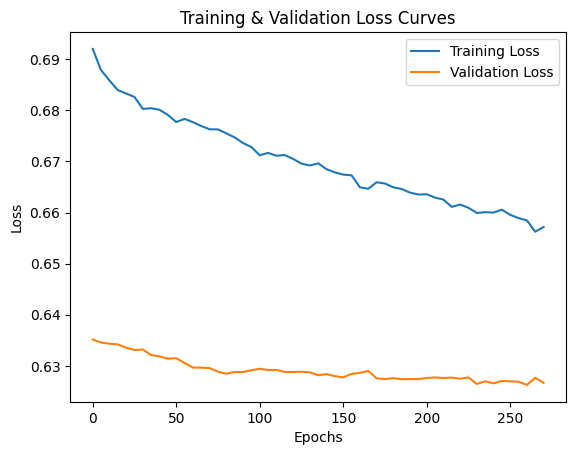

In [33]:
from matplotlib import pyplot as plt


plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## DNN using Pytorch

In [ ]:
import torch
from torch import nn

In [ ]:
x_data = torch.tensor(X_train, dtype=torch.float32)
y_data = torch.tensor(Y_train, dtype=torch.float32)

type(x_data), type(y_data)

(torch.Tensor, torch.Tensor)

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [63]:
class DnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(126, 64)
        self.linear2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        # return self.linear2(self.dropout(self.relu(self.linear1(x))))
        return self.linear2(self.relu(self.linear1(x)))

In [64]:
model = DnnModel().to(device)
model

DnnModel(
  (linear1): Linear(in_features=126, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [65]:
learning_rate = 0.003

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [66]:
# Forward pass
logits = model(x_data)
logits

tensor([[-11.7944],
        [ -8.6314],
        [ -9.1313],
        ...,
        [-10.2376],
        [-10.2376],
        [-10.2376]], grad_fn=<AddmmBackward0>)

In [67]:
pred_probab = torch.round(torch.sigmoid(logits))
pred_probab

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [68]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [ ]:
# Number of epochs
epochs = 10000

# Send data to the device
x_train, x_valid = x_data.to(device), X_train.reshape((X_train.shape[0], 3, 42)).to(device)
y_train, y_valid = y_data.to(device), Y_train.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
    y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

    loss = loss_fn(y_logits, y_train) # compute the loss   
    acc = accuracy_fn(y_train.int(), y_pred) # calculate the accuracy; convert the labels to integers

    optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
    loss.backward() # backward pass: backpropagate the prediction loss
    optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass
    
    # Put the model in evaluation mode
    model.eval() 

    with torch.inference_mode():
        valid_logits = model(x_valid).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_logits))    

        valid_loss = loss_fn(valid_logits, y_valid)
        valid_acc = accuracy_fn(y_valid.int(), valid_pred)    
    
    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 4.31612, Accuracy: 54.14% | Validation Loss: 78.19381, Accuracy: 45.81%
Epoch:  500 | Train Loss: 0.67082, Accuracy: 55.35% | Validation Loss: 0.67079, Accuracy: 55.42%
Epoch: 1000 | Train Loss: 0.66015, Accuracy: 56.89% | Validation Loss: 0.66103, Accuracy: 57.32%
Epoch: 1500 | Train Loss: 0.65276, Accuracy: 60.08% | Validation Loss: 0.65523, Accuracy: 61.14%
Epoch: 2000 | Train Loss: 0.64739, Accuracy: 60.90% | Validation Loss: 0.65058, Accuracy: 61.42%
Epoch: 2500 | Train Loss: 0.64317, Accuracy: 61.62% | Validation Loss: 0.64352, Accuracy: 62.28%
Epoch: 3000 | Train Loss: 0.64094, Accuracy: 62.05% | Validation Loss: 0.64125, Accuracy: 62.45%
Epoch: 3500 | Train Loss: 0.63822, Accuracy: 62.24% | Validation Loss: 0.63898, Accuracy: 62.40%
Epoch: 4000 | Train Loss: 0.63708, Accuracy: 62.21% | Validation Loss: 0.63841, Accuracy: 62.38%
Epoch: 4500 | Train Loss: 0.63442, Accuracy: 62.94% | Validation Loss: 0.63600, Accuracy: 62.67%
Epoch: 5000 | Train Loss: 0.6

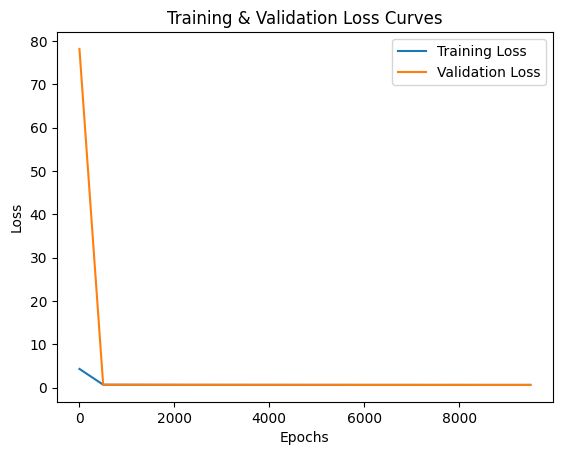

In [70]:
from matplotlib import pyplot as plt


plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import roc_auc_score


y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels

print('roc_auc_score', roc_auc_score(trainY, y_logits.detach().numpy()))

NameError: name 'trainY' is not defined

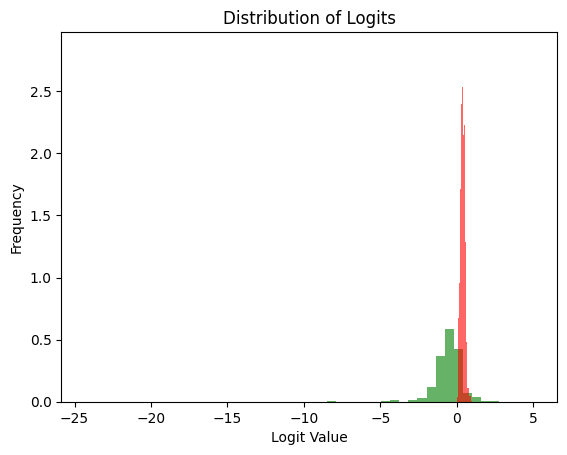

In [19]:
y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
    # y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities
# Create the histogram
plt.hist(y_logits.detach().numpy(), bins=50, density=True, alpha=0.6, color='g')
plt.hist(torch.sigmoid(y_logits).detach().numpy(), bins=50, density=True, alpha=0.6, color='r')

# Add labels and title
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.title('Distribution of Logits')

# Display the plot
plt.show()

## Traditional ML

### NB Classifier model

In [20]:
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_score = gnb.fit(trainX.reshape((trainX.shape[0], 126)), trainY).predict_proba(trainX.reshape((trainX.shape[0], 126)))
y_pred = gnb.fit(trainX.reshape((trainX.shape[0], 126)), trainY).predict(trainX.reshape((trainX.shape[0], 126)))


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(trainY, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(trainY, y_pred))
print('F1 Score', f1_score(trainY, y_pred))
print('Precision Score', precision_score(trainY, y_pred))
print('Recall Score', recall_score(trainY, y_pred))
print('roc_auc_score', roc_auc_score(trainY, [y[1] for y in y_score]))

Accuracy 0.45150716945258657
Balanced Accuracy 0.5127751473308843
F1 Score 0.6036990662898437
Precision Score 0.43901474551755
Recall Score 0.9661079051021343
roc_auc_score 0.5520657727286469


### LR Classifier

In [22]:
from sklearn.linear_model import LogisticRegression


lrc = LogisticRegression(random_state=0)
y_score = lrc.fit(trainX.reshape((trainX.shape[0], 126)), trainY).predict_proba(trainX.reshape((trainX.shape[0], 126)))
y_pred = lrc.fit(trainX.reshape((trainX.shape[0], 126)), trainY).predict(trainX.reshape((trainX.shape[0], 126)))

/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(trainY, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(trainY, y_pred))
print('F1 Score', f1_score(trainY, y_pred))
print('Precision Score', precision_score(trainY, y_pred))
print('Recall Score', recall_score(trainY, y_pred))
print('roc_auc_score', roc_auc_score(trainY, [y[1] for y in y_score]))

Accuracy 0.6113740790620297
Balanced Accuracy 0.5860275476919845
F1 Score 0.4699987845557551
Precision Score 0.572796997926199
Recall Score 0.3984840157552441
roc_auc_score 0.6346665575185908


### XGBoost Classifier

In [24]:
from xgboost import XGBClassifier

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(trainX.reshape((trainX.shape[0], 126)), trainY)
# make predictions
y_score = bst.predict_proba(trainX.reshape((trainX.shape[0], 126)))
y_pred = bst.predict(trainX.reshape((trainX.shape[0], 126)))

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(trainY, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(trainY, y_pred))
print('F1 Score', f1_score(trainY, y_pred))
print('Precision Score', precision_score(trainY, y_pred))
print('Recall Score', recall_score(trainY, y_pred))
print('roc_auc_score', roc_auc_score(trainY, [y[1] for y in y_score]))

Accuracy 0.6309118276162561
Balanced Accuracy 0.5879355014779707
F1 Score 0.38745727057586116
Precision Score 0.6861466821885914
Recall Score 0.26994595584867637
roc_auc_score 0.6589225850331368
